In [1]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
from skimage import io
from tqdm.notebook import tqdm, trange
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib.patches import Patch
import matplotlib 

sc.settings.verbosity = 3


In [2]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [3]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

In [4]:
donors = [
    "LN Donor A",
    "LN Donor E",
    "INT Donor B",
    "INT Donor E",
    "TS Donor A",
    "TS Donor E",
]


# Read Data

In [5]:
from skimage import exposure 

def contrast_streching(img):
    p2, p98 = np.percentile(img, (0.5, 99.5))
    img = exposure.rescale_intensity(img, in_range=(p2, p98), out_range=(0, 255)).astype(np.uint8)
    return img

In [6]:
# Read single-cell data
adata_path = data_dir / "metadata" / f"combined_semi_final.h5ad"
adata = sc.read_h5ad(adata_path)

In [7]:
marker = 'COL1'
imgs_col = []

# Read COL1 images
for donor in donors:
    path = p_dir / "data" / "whole_stitched"/ donor / f"{marker}.tif"
    
    img = skimage.io.imread(path)

    img_col= contrast_streching(img)
    if donor == 'INT Donor B':
        img_col = img_col[:5000, :]
    imgs_col.append(img_col)
    

In [8]:
# rename_dict = {'Activated B':'B-cells',  'B-cells MZ':'B-cells', 'CD38+': 'Stroma', 
#                'Stroma Vimentin+': 'Stroma'
#               }
# rename_dict = {'Activated B':'B-cells',  'B-cells MZ':'B-cells', 
#                'Stroma Vimentin+': 'Stroma'
#               }
rename_dict = {'CD38+': 'Stroma', 
               'Stroma Vimentin+': 'Stroma'
              }
# Rename a cluster
adata.obs["cluster"] = adata.obs["Phenotype"].map(lambda x: rename_dict.get(x, x)).astype('category')


In [9]:
np.unique(adata.obs.cluster)

array(['Activated B', 'B-cells', 'B-cells MZ', 'Cytotoxic T-cells',
       'DZ B-cells', 'Exhausted T-cells', 'FDC', 'Helper T-cells',
       'LZ B-cells', 'Other', 'Stroma', 'TFH', 'Treg',
       'myeloid-derived cells'], dtype=object)

In [10]:
rename_dict = {'Cytotoxic T-cells': 'Other', 'Exhausted T-cells': 'Other',
       'FDC':'Other', 'Helper T-cells': 'Other', 'Stroma': 'Other', 'TFH':'Other',
       'Treg': 'Other', 'myeloid-derived cells': 'Other', }

adata_subset = adata[:, ['CD38', 'CD20', 'CD27']]

X = np.array(adata_subset.X)
cd38_val = X[:, 0]
cd20_val = X[:, 1]
cd27_val = X[:, 2]
gate = (cd20_val > 0) & (cd38_val<-0.4) & (cd27_val > 0)

adata.obs['cluster_new'] = adata.obs['cluster'].map(lambda x: rename_dict.get(x, x))
adata.obs['cluster_new'][gate] = 'Memory B'
adata.obs['cluster_new'] = adata.obs['cluster_new'].astype('category')

np.random.seed(2)
adata.uns['cluster_new_colors'] = np.random.choice(adata.uns['Phenotype_colors'], len(np.unique(adata.obs['cluster_new'])), replace=False, )
adata.uns['cluster_new_colors'][-1] = '#808080'

C:\Users\thu71\AppData\Local\Temp\ipykernel_25452\3735848403.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['cluster_new'][gate] = 'Memory B'


In [11]:
np.unique(adata.obs.cluster_new)

array(['Activated B', 'B-cells', 'B-cells MZ', 'DZ B-cells', 'LZ B-cells',
       'Memory B', 'Other'], dtype=object)

In [12]:
# Get adata 
phenotype_name = 'cluster_new'

sc.tl.dendrogram(adata, groupby=phenotype_name)

cluster_label_order = adata.uns[f'dendrogram_{phenotype_name}']['categories_ordered']

# Define colormap
colors = adata.uns[f"{phenotype_name}_colors"]
labels = adata.obs[phenotype_name].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)
colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster_new']`


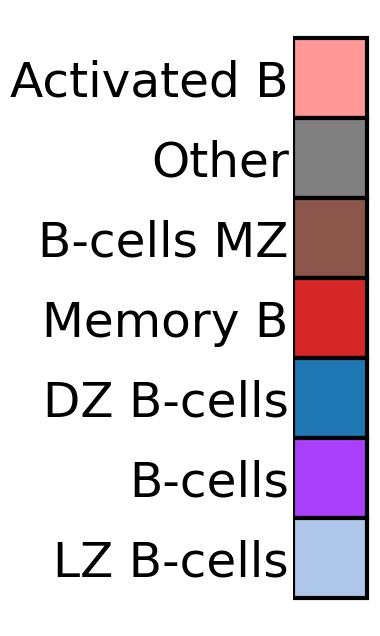

In [13]:
c=np.array([colors_rgb_dict[i] for i in cluster_label_order])

# legend
fig, ax = plt.subplots(figsize=(1,8))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=c/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.yticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=35)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)


# Col analysis

In [14]:
import numpy as np
from scipy.ndimage import distance_transform_edt

def expand_labels(label_image, distance=1):
    distances, nearest_label_coords = distance_transform_edt(
        label_image == 0, return_indices=True
    )
    labels_out = np.zeros_like(label_image)
    dilate_mask = distances <= distance
    # build the coordinates to find nearest labels,
    # in contrast to [1] this implementation supports label arrays
    # of any dimension
    masked_nearest_label_coords = [
        dimension_indices[dilate_mask]
        for dimension_indices in nearest_label_coords
    ]
    nearest_labels = label_image[tuple(masked_nearest_label_coords)]
    labels_out[dilate_mask] = nearest_labels
    return labels_out

In [15]:
from skimage.measure import block_reduce
from skimage import filters 

def mean_block(img, size):
    reduced = block_reduce(img_col, block_size=(size, size), func=np.mean)
    # reduced = filters.gaussian(reduced, sigma=1)
    img_mean = np.repeat(reduced, size, axis=0)
    img_mean = np.repeat(img_mean, size, axis=1)
    img_mean[:img.shape[0], :img.shape[1]]
    img_mean = filters.gaussian(img_mean, sigma=10)
    return reduced, img_mean 

In [16]:
from skimage import morphology
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

def create_gradient(mask, size=100, n=5):
    mask = morphology.remove_small_objects(mask, min_size=10000)
    mask_grad = (mask*1).astype(np.uint8)    
    for i in range(2, n+2):
        mask_expanded = expand_labels(mask_grad, distance=size)
        mask_expanded = np.where(mask_expanded>0, mask_expanded+1, 0) 
        mask_grad = np.where(mask_grad>0, mask_grad, mask_expanded) 
    return mask_grad

In [17]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

# get colormap
ncolors = 100
color_array = plt.get_cmap('Wistia')(range(ncolors))

# change alpha values
color_array[:,-1] = np.zeros(ncolors)
color_array[ncolors//4:, -1] = np.linspace(0.0,1.0, ncolors-ncolors//4)

# create a colormap object
mycmap_y= LinearSegmentedColormap.from_list(name='mycmap_y', colors=color_array)


(5000, 4000)


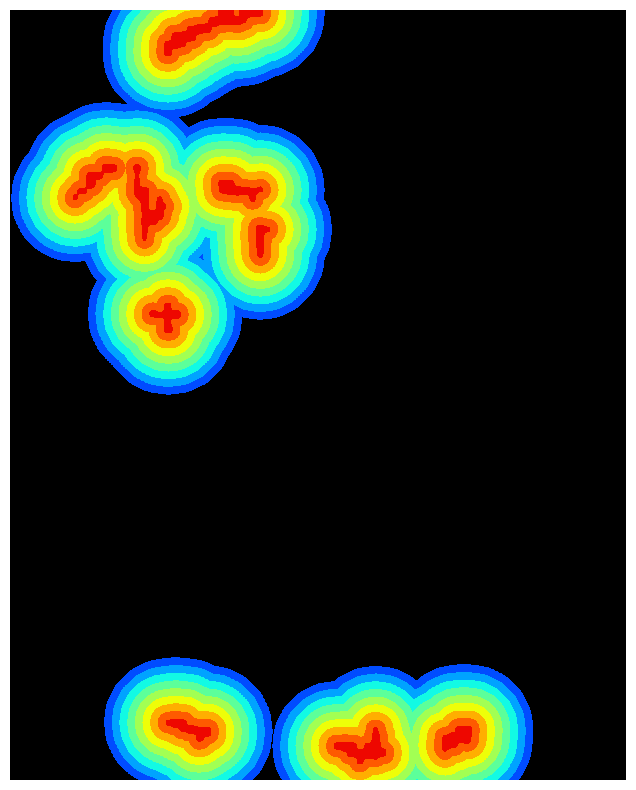

(2000, 9000)


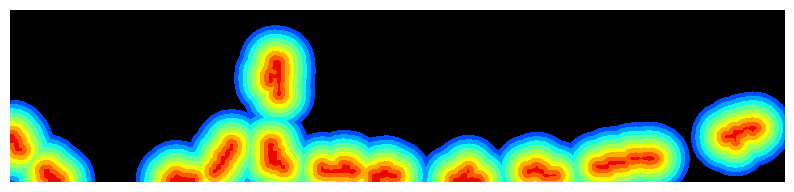

(5000, 4000)


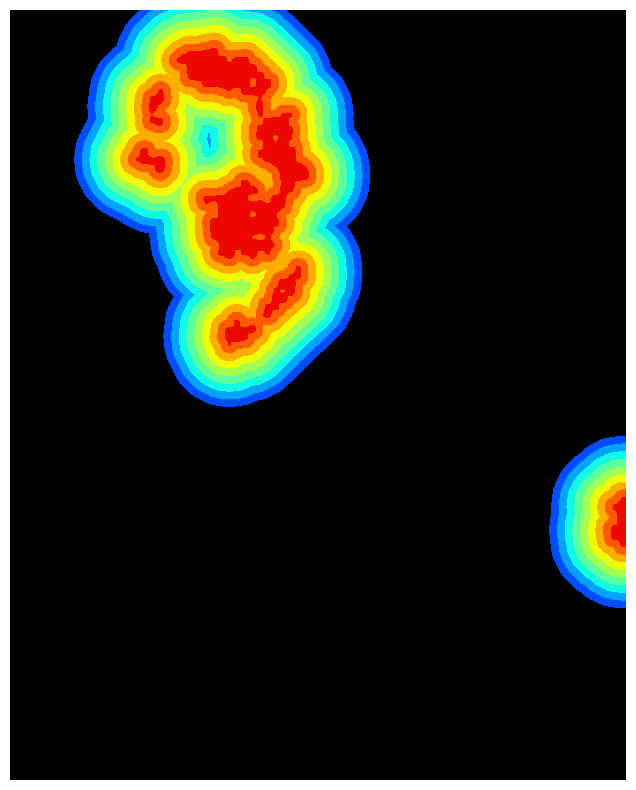

(5000, 5000)


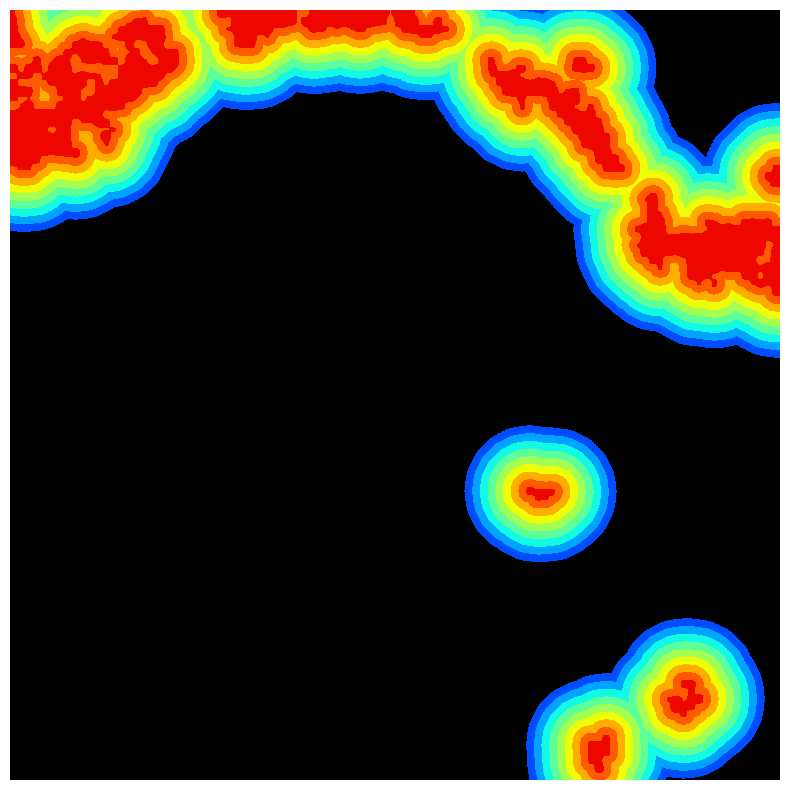

(2000, 7000)


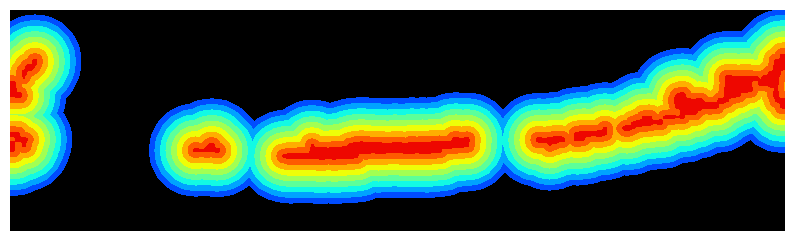

(6000, 3000)


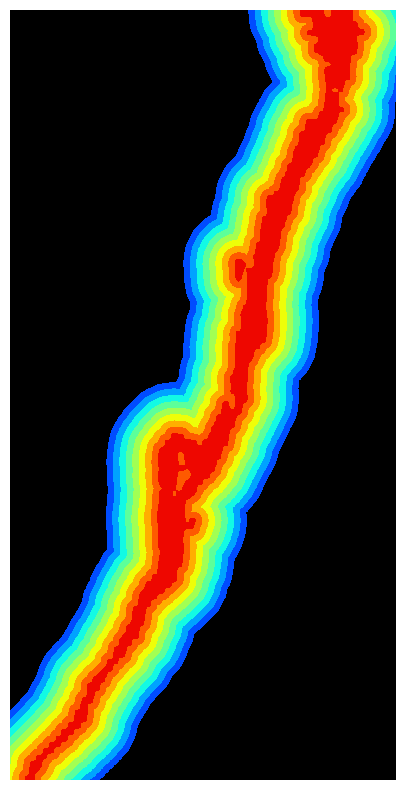

In [18]:
size = 50
thresh = 60
masks_grad = []
n = 8
pad_size = 50

# get colormap
ncolors = n+1
color_array = plt.get_cmap('jet_r')(np.linspace(0.1, 0.8, ncolors))

# change alpha values
color_array = np.vstack([np.array([0,0,0,1]), color_array])

# create a colormap object
mycmap= LinearSegmentedColormap.from_list(name='mycmap', colors=color_array)

for i in range(len(donors)):
    # Read COL image and follicle mask
    img_col = imgs_col[i]
    print(img_col.shape)
    
    # Get average marker image
    _, img_mean = mean_block(img_col, size)
    img_mean_pos = img_mean > thresh
    
    # Get Gradient image
    mask_grad = create_gradient(img_mean_pos, size=pad_size, n=n)
    masks_grad.append(mask_grad)
    
    # fig, ax = plt.subplots(figsize=(10,10))
    # ax.imshow(img_mean)
    # ax.axis('off')
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(mask_grad, cmap=mycmap, interpolation='none')
    ax.axis('off')
    
    plt.show()


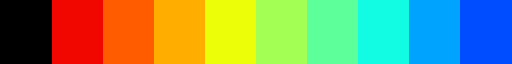

In [19]:
# create a colormap object
ListedColormap(colors=color_array)

In [20]:
dfs_pheno = []
for i in range(len(donors)):
    adata_donor = adata[adata.obs.Dataset == donors[i]]
    X = np.array(adata_donor.obsm['spatial'])[:,[1,0]].astype(int)
    df_pheno = pd.DataFrame(adata_donor.obs['cluster_new'])
    mask_grad = masks_grad[i]
    zones = mask_grad[X[:,0], X[:,1]]
    df_pheno['Zone'] = zones
    df_pheno['Donor'] = donors[i]
    dfs_pheno.append(df_pheno)

In [21]:
df_pheno = pd.concat(dfs_pheno)

In [22]:
df_count = df_pheno.groupby(['Donor', 'Zone'])[['cluster_new']].value_counts()
df_count = df_count.reset_index()
df_count.columns = ['Donor', 'Zone', 'cluster', 'Count']
df_count = df_count[df_count.Zone != 0]

In [23]:
df_count.head()

Donor  Zone      cluster  Count
7   INT Donor B     1        Other   2506
8   INT Donor B     1   DZ B-cells    397
9   INT Donor B     1   B-cells MZ    284
10  INT Donor B     1  Activated B     98
11  INT Donor B     1   LZ B-cells     66

In [24]:
df_pivot = df_count.pivot(index=['Zone', 'Donor'], columns='cluster', values='Count') + 1
df_pivot = df_pivot.div(df_pivot.sum(axis=1), axis=0)

In [25]:
df_pivot

cluster           Activated B   B-cells  B-cells MZ  DZ B-cells  LZ B-cells  \
Zone Donor                                                                    
1    INT Donor B     0.028998  0.005858    0.083480    0.116579    0.019625   
     INT Donor E     0.005826  0.001258    0.154330    0.004833    0.008077   
     LN Donor A      0.002347  0.023474    0.012911    0.003521    0.002347   
     LN Donor E      0.001074  0.033816    0.048846    0.006441    0.002684   
     TS Donor A      0.011918  0.002923    0.054194    0.006296    0.000899   
     TS Donor E      0.003235  0.000340    0.007150    0.000851    0.000170   
2    INT Donor B     0.029902  0.011275    0.096814    0.109559    0.057843   
     INT Donor E     0.010697  0.003336    0.150794    0.025535    0.046124   
     LN Donor A      0.001572  0.193819    0.015191    0.009429    0.071765   
     LN Donor E      0.001895  0.257522    0.030325    0.013504    0.044302   
     TS Donor A      0.013141  0.011182    0.061210    0.028473    0.010490   
     TS Donor E      0.001513  0.011641    0.013853    0.014901    0.003027   
3    INT Donor B     0.025214  0.008813    0.083476    0.109914    0.090575   
     INT Donor E     0.018315  0.004884    0.085334    0.048704    0.123728   
     LN Donor A      0.003569  0.169310    0.009516    0.014671    0.172086   
     LN Donor E      0.003652  0.277231    0.013338    0.023976    0.196094   
     TS Donor A      0.009371  0.009371    0.033879    0.080012    0.025847   
     TS Donor E      0.001826  0.016543    0.009238    0.071651    0.032871   
4    INT Donor B     0.019703  0.012416    0.065047    0.104723    0.121188   
     INT Donor E     0.036505  0.006061    0.052149    0.047357    0.169697   
     LN Donor A      0.003036  0.114372    0.011808    0.011808    0.215250   
     LN Donor E      0.002972  0.216383    0.017715    0.021876    0.299727   
     TS Donor A      0.008631  0.007288    0.025892    0.137323    0.037495   
     TS Donor E      0.000832  0.019251    0.004058    0.114152    0.076587   
5    INT Donor B     0.020091  0.017352    0.068493    0.113851    0.117504   
     INT Donor E     0.036300  0.004501    0.031654    0.060113    0.233774   
     LN Donor A      0.004324  0.096356    0.021618    0.007412    0.221124   
     LN Donor E      0.003131  0.158889    0.019798    0.031818    0.327677   
     TS Donor A      0.005195  0.006772    0.016976    0.168738    0.042950   
     TS Donor E      0.000316  0.011591    0.002845    0.134879    0.092308   
6    INT Donor B     0.016790  0.014439    0.058093    0.104433    0.111148   
     INT Donor E     0.029491  0.004042    0.019311    0.063174    0.246108   
     LN Donor A      0.003459  0.076391    0.026521    0.011531    0.219948   
     LN Donor E      0.002438  0.130789    0.024377    0.037784    0.334896   
     TS Donor A      0.004828  0.006934    0.018081    0.165014    0.045115   
     TS Donor E      0.000324  0.011324    0.002912    0.133089    0.092645   
7    INT Donor B     0.011582  0.008686    0.045241    0.084691    0.152371   
     INT Donor E     0.035670  0.005074    0.021218    0.050277    0.227245   
     LN Donor A      0.002362  0.088189    0.038583    0.009974    0.196063   
     LN Donor E      0.001936  0.119225    0.025634    0.045735    0.333241   
     TS Donor A      0.005193  0.007356    0.015232    0.176633    0.047166   
     TS Donor E      0.000450  0.010002    0.003709    0.115082    0.083165   
8    INT Donor B     0.013820  0.007294    0.029175    0.088676    0.104031   
     INT Donor E     0.049246  0.002366    0.018781    0.051168    0.172878   
     LN Donor A      0.001806  0.091824    0.066546    0.010575    0.138509   
     LN Donor E      0.002321  0.109945    0.028693    0.063051    0.286563   
     TS Donor A      0.005660  0.009375    0.018926    0.171044    0.052799   
     TS Donor E      0.000462  0.016038    0.003923    0.088612    0.072690   
9    INT Donor B     0.014793  0.016642    0.02699

Other


C:\Users\thu71\AppData\Local\Temp\ipykernel_25452\840424085.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:, 'Tissue'] = df_subset['Donor'].str[:-2]


DZ B-cells


C:\Users\thu71\AppData\Local\Temp\ipykernel_25452\840424085.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:, 'Tissue'] = df_subset['Donor'].str[:-2]


B-cells MZ


C:\Users\thu71\AppData\Local\Temp\ipykernel_25452\840424085.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:, 'Tissue'] = df_subset['Donor'].str[:-2]


Activated B


C:\Users\thu71\AppData\Local\Temp\ipykernel_25452\840424085.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:, 'Tissue'] = df_subset['Donor'].str[:-2]


LZ B-cells


C:\Users\thu71\AppData\Local\Temp\ipykernel_25452\840424085.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:, 'Tissue'] = df_subset['Donor'].str[:-2]


Memory B


C:\Users\thu71\AppData\Local\Temp\ipykernel_25452\840424085.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:, 'Tissue'] = df_subset['Donor'].str[:-2]


B-cells


C:\Users\thu71\AppData\Local\Temp\ipykernel_25452\840424085.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:, 'Tissue'] = df_subset['Donor'].str[:-2]


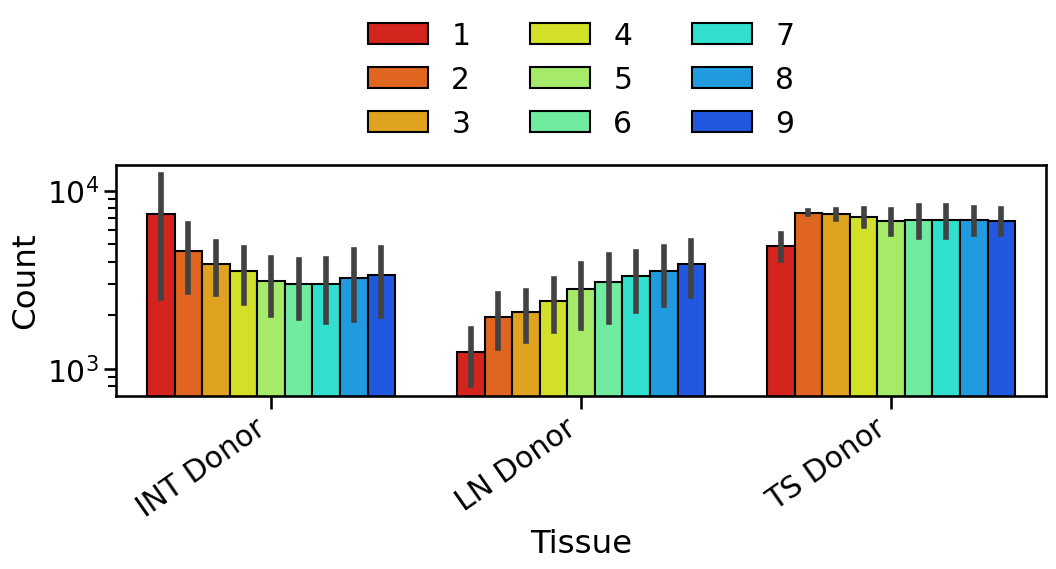

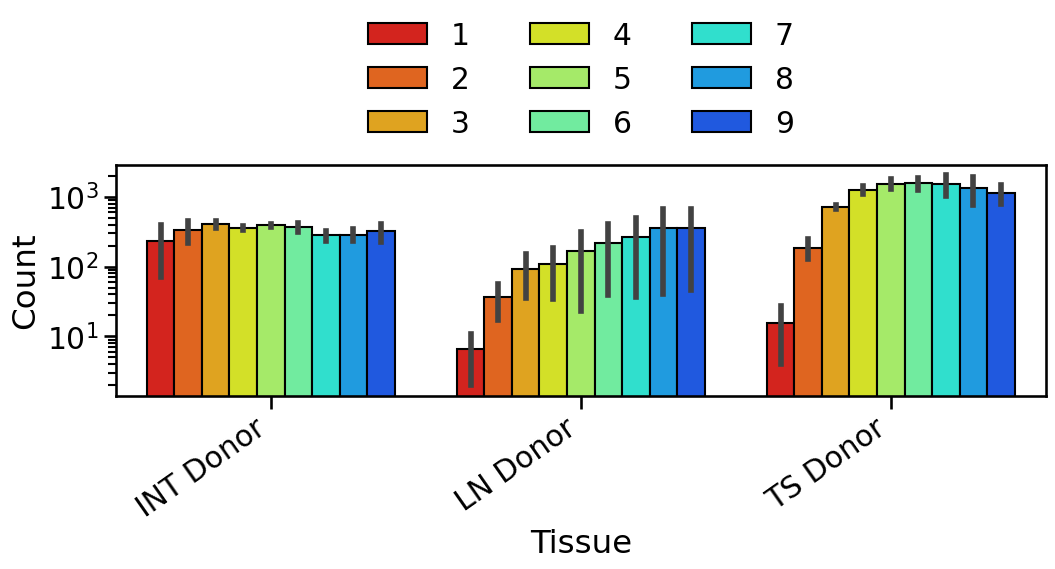

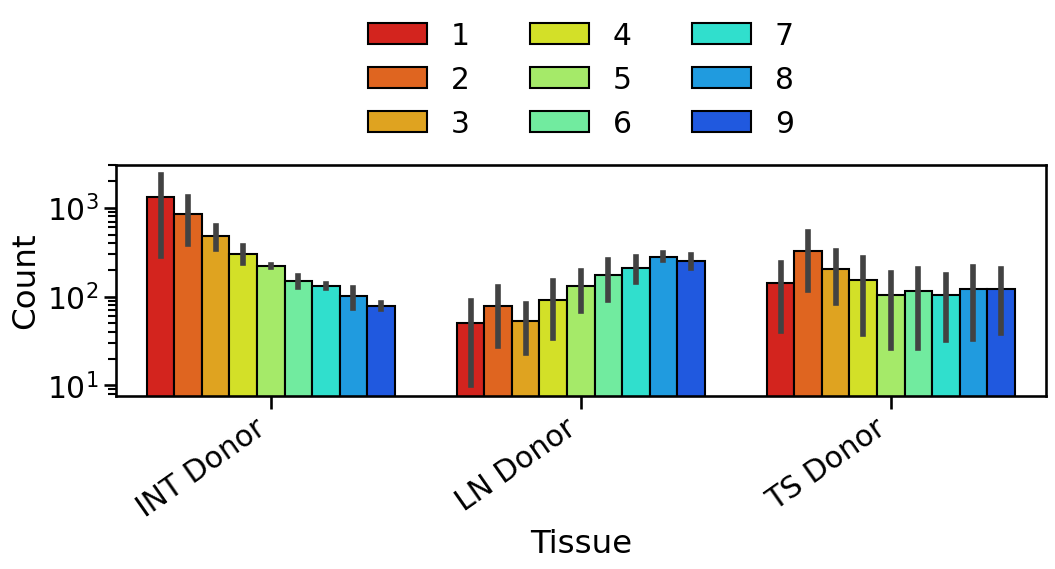

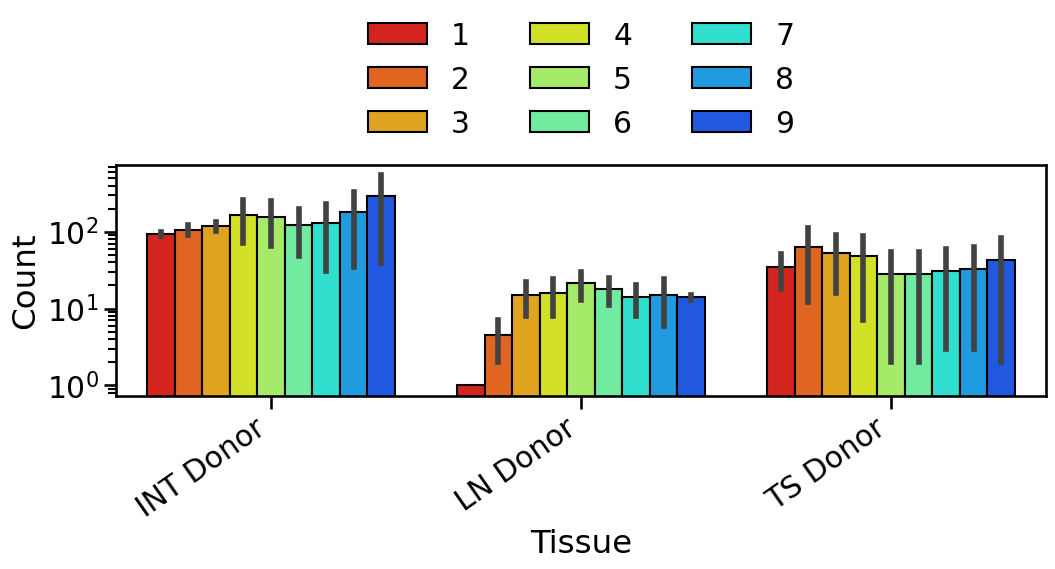

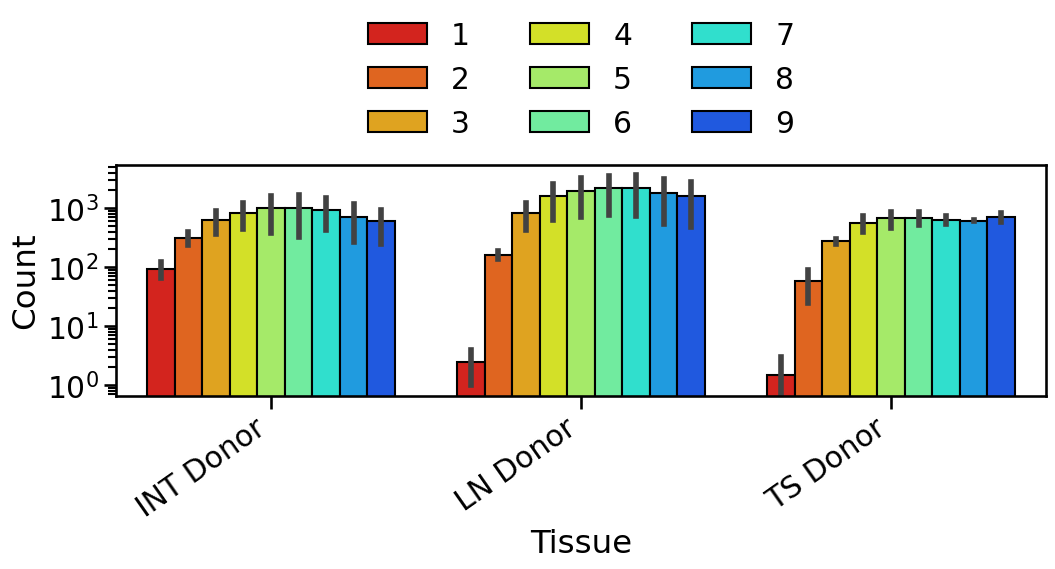

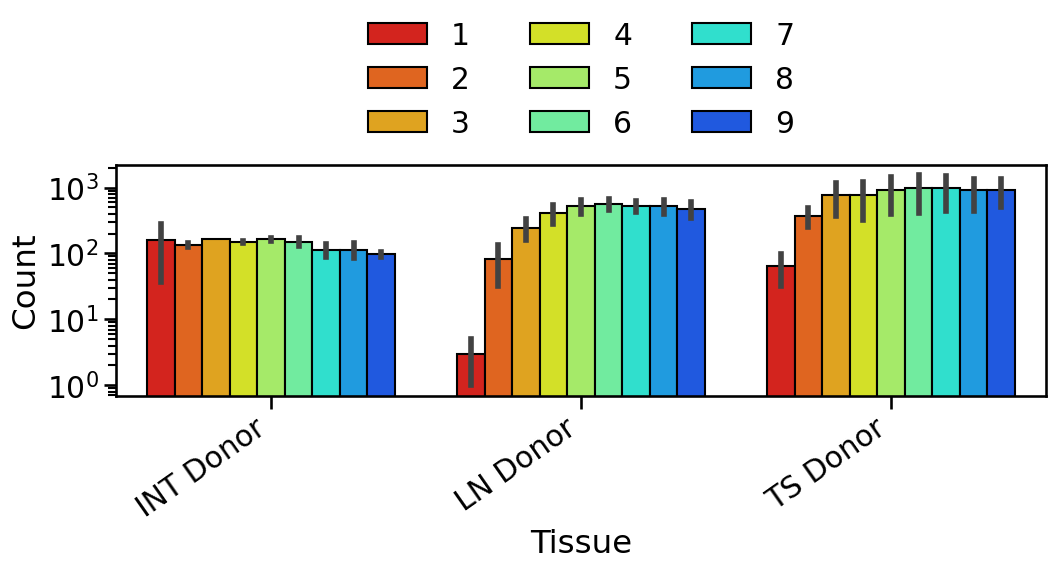

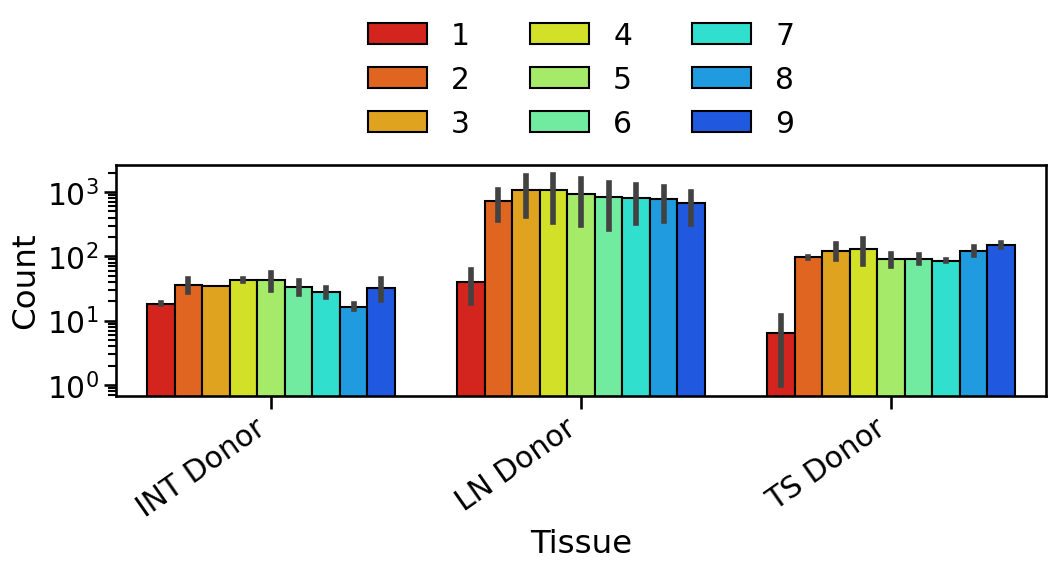

In [26]:
for c in df_count.cluster.unique():
    print(c)
    df_subset = df_count[df_count.cluster == c]
    df_subset.loc[:, 'Tissue'] = df_subset['Donor'].str[:-2]
    with sns.plotting_context('talk', font_scale=1.3):
        fig,ax = plt.subplots(figsize=(12,3))
        g = sns.barplot(data=df_subset, x="Tissue", y="Count", hue="Zone", ax=ax, palette=color_array[1:],
                   edgecolor='k')
        sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
        g.set_yscale("log")
        plt.xticks(rotation=35, ha='right')

# Plot

In [27]:
# Plot clustered cell within each mask
import matplotlib 
from PIL import Image
from skimage import measure 

def create_clustered_cell(mask, label2cell, my_cmap, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1],3), dtype=np.uint8)

    # for i, cells in tqdm(label2cell.items(), total=len(label2cell), leave=False):
    for i, cells in label2cell.items():
        rows, cols = np.where(np.isin(mask, cells))
        img[rows, cols, :] = my_cmap[int(i)]
    return img


def get_img_size(roi_dict, size=1000):
    row_max = 0
    col_max = 0
    for k, v in roi_dict.items():
        row_max = max(row_max, v[0])
        col_max = max(col_max, v[1])
    return row_max + size, col_max + size

# Read mask image
def get_masks(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition =  name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks

from skimage import exposure 

def contrast_streching(img):
    p2, p98 = np.percentile(img, (1, 99))
    img = exposure.rescale_intensity(img, in_range=(p2, p98), out_range=(0, 255)).astype(np.uint8)
    return img

In [28]:
# Format row, col
arrangement = {
    "LN Donor A": {
        1: [0, 1000],
        2: [0, 2000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [1000, 2000],
        6: [1000, 3000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [2000, 3000],
        11: [3000, 0],
        12: [3000, 1000],
        13: [3000, 2000],
        14: [3000, 3000],
        15: [4000, 1000],
        16: [4000, 2000],
    },
    "LN Donor E": {
        1: [1000, 0],
        2: [1000, 1000],
        3: [1000, 2000],
        4: [1000, 3000],
        5: [1000, 4000],
        6: [1000, 5000],
        7: [1000, 6000],
        8: [1000, 7000],
        9: [1000, 8000],
        10: [0, 0],
        11: [0, 1000],
        12: [0, 2000],
        13: [0, 3000],
        14: [0, 4000],
    },
    "INT Donor B": {
        1: [0, 0],
        2: [0, 1000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [2000, 0],
        6: [2000, 1000],
        7: [2000, 2000],
        8: [2000, 3000],
        9: [3000, 0],
        10: [3000, 1000],
        11: [3000, 2000],
        12: [3000, 3000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [4000, 3000],
        # 17: [5000, 0],
        # 18: [5000, 1000],
        # 19: [5000, 2000],
        # 20: [5000, 3000],
    },
    "INT Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        # 5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 3000],
        12: [2000, 4000],
        13: [3000, 3000],
        14: [3000, 4000],
        15: [4000, 3000],
        16: [4000, 4000],
    },
    "TS Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [0, 5000],
        7: [0, 6000],
        8: [1000, 0],
        9: [1000, 1000],
        10: [1000, 2000],
        11: [1000, 3000],
        12: [1000, 4000],
        13: [1000, 5000],
        14: [1000, 6000],
    },
    "TS Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [1000, 0],
        5: [1000, 1000],
        6: [1000, 2000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [3000, 0],
        11: [3000, 1000],
        12: [3000, 2000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [5000, 0],
        17: [5000, 1000],
        18: [5000, 2000],
    },
    "SP Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 0],
        12: [2000, 1000],
        13: [2000, 2000],
        14: [2000, 3000],
        15: [2000, 4000],
        16: [3000, 0],
        17: [3000, 1000],
        18: [3000, 2000],
        19: [3000, 3000],
        20: [3000, 4000],
    },
}

In [29]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

# get colormap
ncolors = 250
color_array = plt.get_cmap('plasma')(range(ncolors))

# change alpha values
color_array[:,-1] = np.zeros(ncolors)
color_array[ncolors//2:, -1] = np.linspace(0.0, 1.0, ncolors//2)

# create a colormap object
mycmap= LinearSegmentedColormap.from_list(name='mycmap', colors=color_array)


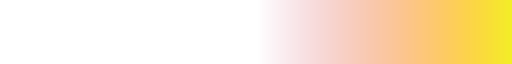

In [30]:
mycmap

In [31]:
marker = 'COL1'
imgs_col = []

# Read COL1 images
for donor in donors:
    path = p_dir / "data" / "whole_stitched"/ donor / f"{marker}.tif"
    
    img = skimage.io.imread(path)

    img_col= contrast_streching(img)
    if donor == 'INT Donor B':
        img_col = img_col[:5000, :]
    imgs_col.append(img_col)

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster_new']`
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster_new']`
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster_new']`
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster_new']`
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster_new']`
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster_new']`


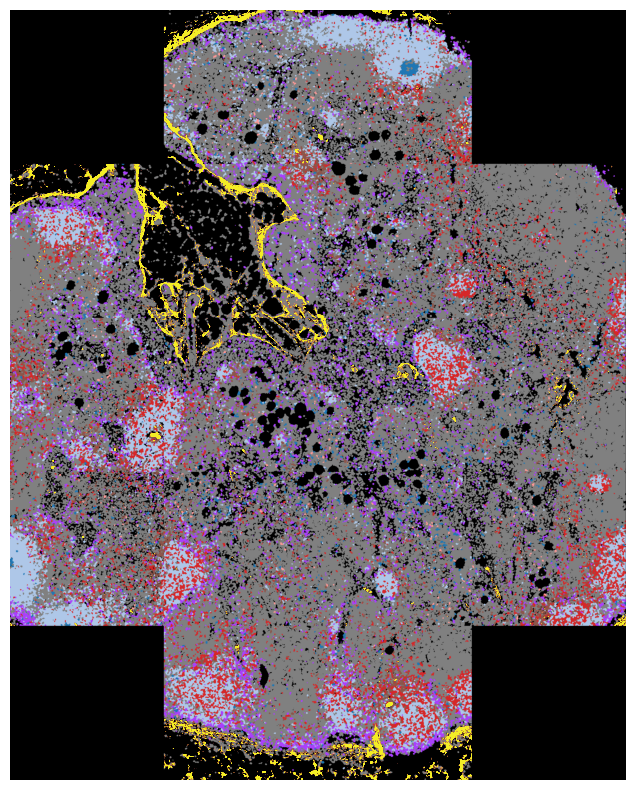

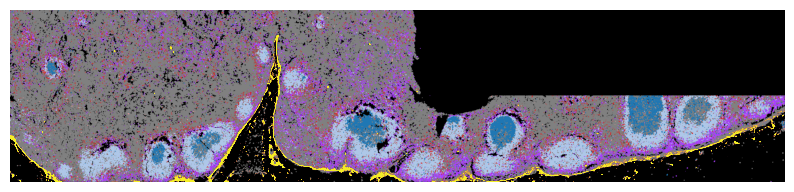

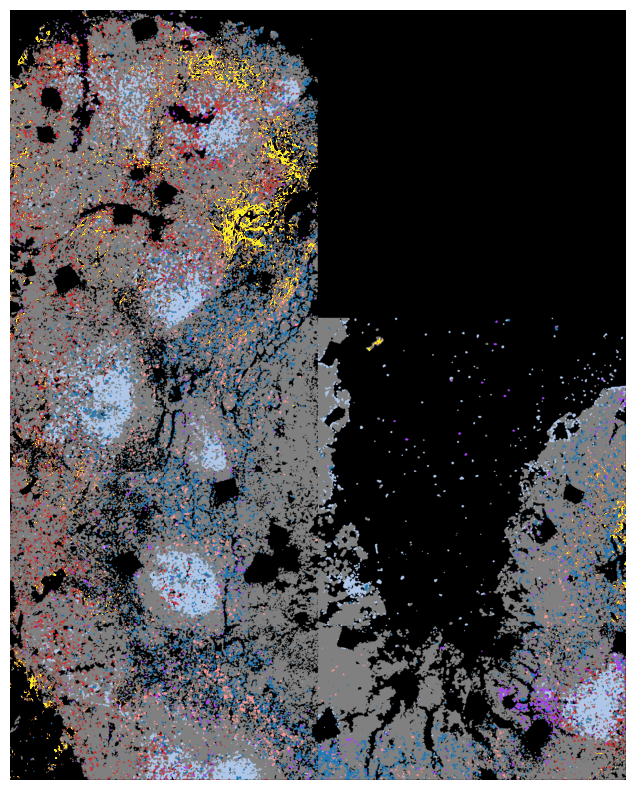

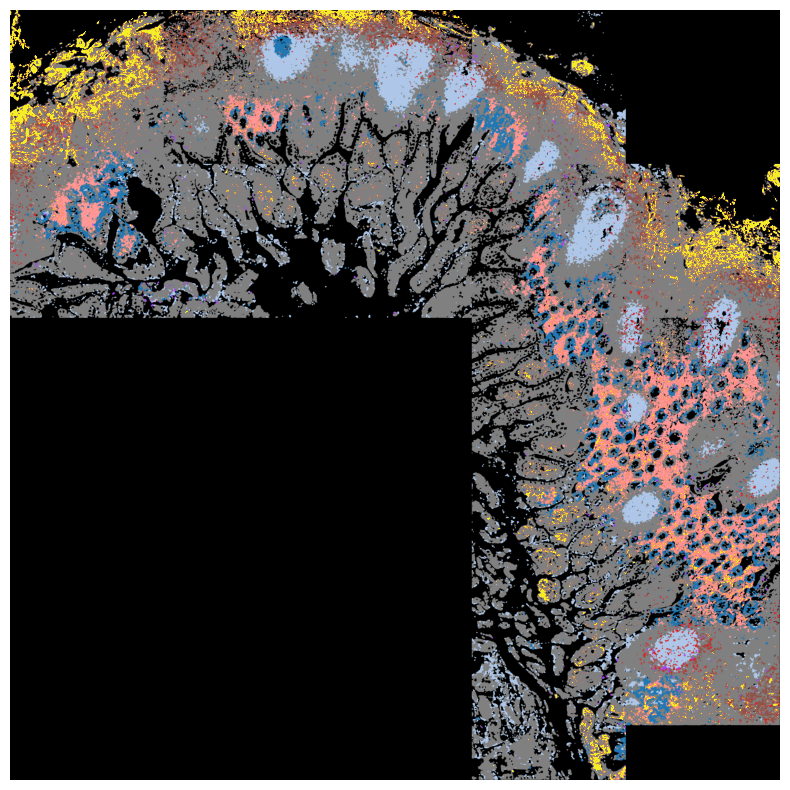

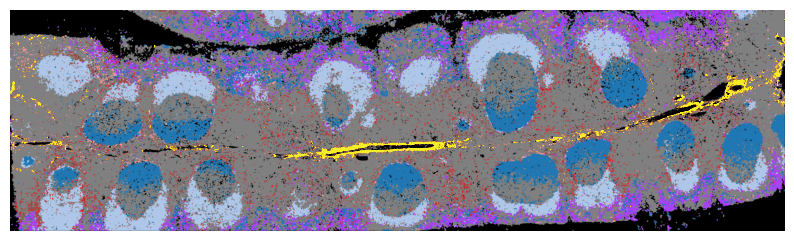

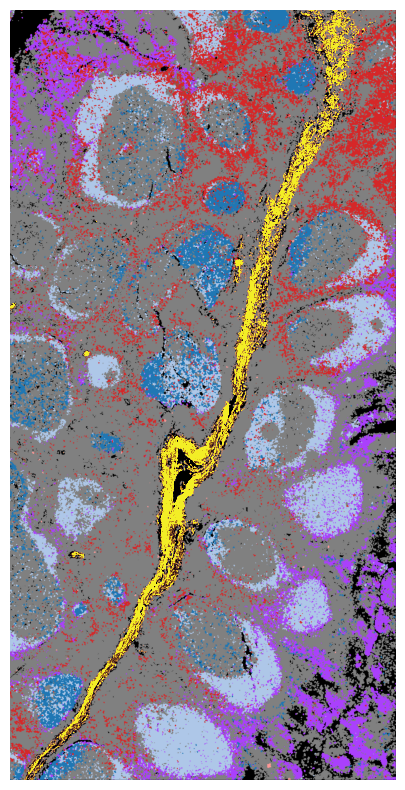

In [32]:
for i, donor in enumerate(donors):
    img_col = imgs_col[i]
# Get mask
    masks = get_masks(data_dir / "masks" / donor)

    # Get adata 
    phenotype_name = 'cluster_new'

    sc.tl.dendrogram(adata, groupby=phenotype_name)

    # Define colormap
    colors = adata.uns[f"{phenotype_name}_colors"]
    labels = adata.obs[phenotype_name].cat.categories.tolist()

    colors_rgb = []
    for color in colors:
        colors_rgb.append(matplotlib.colors.hex2color(color))
    colors_rgb = np.array(colors_rgb) * 255
    colors_rgb = colors_rgb.astype(np.uint8)
    colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}
    
    size = 1000 
    adata_donor = adata[adata.obs.Dataset == donor, :]

    # Create combined images
    y_max, x_max = get_img_size(arrangement[donor])
    img_combined = np.zeros((y_max, x_max, 3), dtype=np.uint8)

    # mask_grad = masks_grad[donors.index(donor)]

    for i in adata_donor.obs.ROI.unique():
        if i not in arrangement[donor].keys():
            continue

        # Get dataset
        adata_s = adata_donor[adata_donor.obs.ROI == i, :]
        mask = masks[str(int(i))]

        # Get label2cell dict
        label2cell = {}
        for j, l in enumerate(labels):
            cell_id = adata_s[adata_s.obs[phenotype_name] == l].obs.Cell.to_list()
            label2cell[j] = cell_id

        img = create_clustered_cell(mask, label2cell, colors_rgb)

        # Insert to combine image
        y = max(0, arrangement[donor][i][0] - 1)
        x = max(0, arrangement[donor][i][1] - 1)
        img_combined[y : y + size, x : x + size] = img
        
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(img_combined)
    ax.imshow(img_col, cmap=mycmap, alpha=1, vmax=150)
    ax.axis('off')
    fig.savefig(f'{donor}.png',bbox_inches='tight',transparent=True, pad_inches=0, dpi=450)